# 计算机视觉数据

此模块包含定义处理Image对象及其转换的数据集的类。 像往常一样，在我们进入详细的API文档之前，我们将从快速概述开始。

在完成任何工作之前，需要将数据集转换为DataBunch对象，并且在计算机视觉数据的情况下 - 特别是转换为ImageDataBunch子类。

这是在数据块API和ImageList类及其子类的帮助下完成的。

但是，ImageDataBunch还提供了一组快捷方法，它们将数据块API的多个阶段缩减为单个包装器方法。 这些快捷方式非常适用于：

* Imagenet风格的数据集（ImageDataBunch.from_folder）
* 一个pandas DataFrame，带有一列文件名和一列标签，可以是用于分类的字符串，由label_delim分隔的字符串用于多分类或浮点数用于回归问题（ImageDataBunch.from_df）
* 与上面格式相同的csv文件（ImageDataBunch.from_csv）
* 文件名列表和目标列表（ImageDataBunch.from_lists）
* 文件名列表和从文件名中获取目标的函数（ImageDataBunch.from_name_func）
* 从文件名中获取目标的文件名和正则表达式模式列表（ImageDataBunch.from_name_re）

在最后五种工厂方法中，在列车和验证之间执行随机拆分，在第一种方法中，它可以是随机拆分或与培训和验证文件夹分离。

如果您刚刚开始，您可以选择尝试这些快捷方法，因为它们也用于快速深度学习课程的第一课。 但是，您可以完全跳过它们，并从一开始就使用数据块API开始构建代码。 在内部，这些快捷方式无论如何都使用此API。

本文档的第一部分专门介绍了ImageDataBunch工厂方法的快捷方式。 然后，呈现与数据块API一起使用的所有其他计算机视觉数据特定方法。

---

## 快速准备好数据以进行培训

为了让您尽可能轻松地入门，fastai提供了两个辅助函数来创建一个可以直接用于训练分类器的DataBunch对象。 要演示它们，首先需要通过执行以下单元格来下载和解压缩文件。 这将在data / mnist_sample中创建一个包含MNIST子集的数据文件夹。

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE); path

WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample')

有许多方法可以创建ImageDataBunch。 一种常见的方法是使用ImageData风格的文件夹（请参阅下面的方法了解详细信息）和ImageDataBunch.from_folder：

In [3]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

这里的数据集将在Imagenet风格的文件夹结构中自动创建。 指定的参数：

* 转换应用于ds_tfms中的图像（此处do_flip = False，因为我们不想翻转数字），
* 我们图片的目标尺寸（这里是24）。
与所有DataBunch用法一样，创建了一个类型为PyTorch DataLoader的train_dl和valid_dl。

如果要查看批处理中的一些图像，可以使用DataBunch.show_batch。 rows参数是要显示的行数和列数。

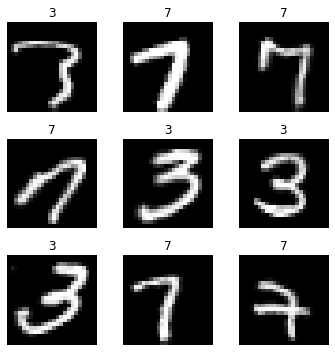

In [5]:
data.show_batch(rows=3, figsize=(5,5))

为分类器定义数据的第二种方法需要这样的结构：

```python
path\
  train\
  test\
  labels.csv
```

其中labels.csv文件定义训练集中每个图像的标签。 这是每个图像可以有多个标签时需要使用的格式。 它也适用于单个标签：

In [6]:
pd.read_csv(path/'labels.csv').head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


然后，您可以使用ImageDataBunch.from_csv：

In [7]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

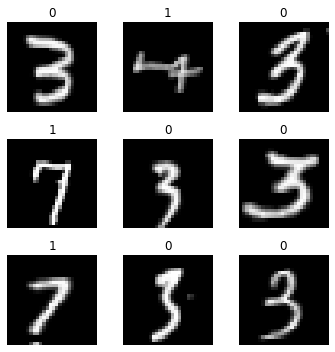

In [8]:
data.show_batch(rows=3, figsize=(5,5))

可以使用以下单元格下载多分类的示例。 这是行星数据集的样本。

In [9]:
planet = untar_data(URLs.PLANET_SAMPLE)

如果我们打开标签文件，我们会搜索每个图像都有一个或多个标签，用空格分隔。

In [10]:
df = pd.read_csv(planet/'labels.csv')
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [11]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim=' ',
    ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

然后show_batchmethod将打印与每个图像对应的所有标签。

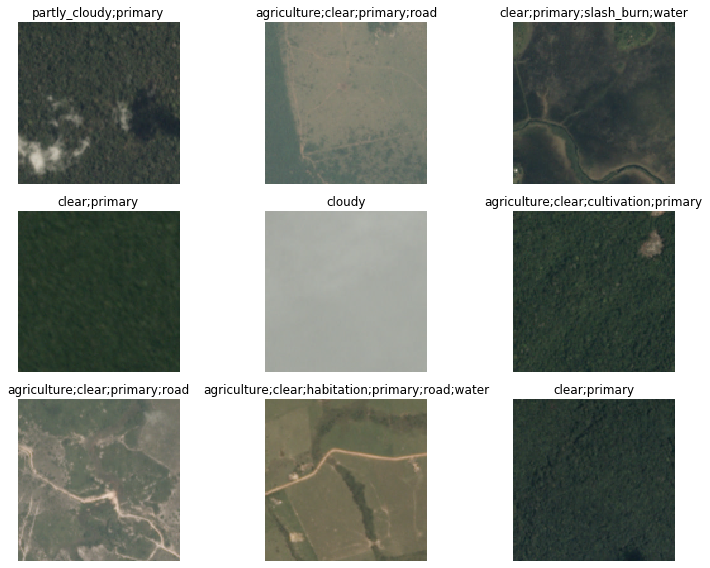

In [12]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

您可以在没有data_block中的工厂方法的情况下找到构建ImageDataBunch的更多方法。

---

## class ImageDataBunch

`ImageDataBunch(train_dl:DataLoader, valid_dl:DataLoader, fix_dl:DataLoader=None, test_dl:Optional[DataLoader]=None, device:device=None, dl_tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.', collate_fn:Callable='data_collate', no_check:bool=False) :: DataBunch`

DataBunch适合计算机视觉。

这与常规DataBunch的初始化相同，因此您可能不希望直接使用它，而是使用其中一种工厂方法。

**工厂方法**

如果您很快想要获得ImageDataBunch并训练模型，则应该处理数据以使其具有以下函数处理的格式之一。

**from_folder**

`from_folder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', valid_pct=None, seed:int=None, classes:Collection[T_co]=None, **kwargs:Any) → ImageDataBunch`

使用train，valid，test子文件夹（或提供valid_pct）从路径中的imagenet样式数据集创建。

请参阅create_from_ll以查看所有** kwargs参数。

“Imagenet风格”数据集看起来像这样（请注意，测试文件夹是可选的）：

```python
path\
  train\
    clas1\
    clas2\
    ...
  valid\
    clas1\
    clas2\
    ...
  test\
```

举个栗子：

In [13]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

请注意，此（以及本节中的所有工厂方法）将任何kwargs传递给DataBunch.create。

**from_csv**

`from_csv(path:PathOrStr, folder:PathOrStr=None, label_delim:str=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2, seed:int=None, fn_col:int=0, label_col:int=1, suffix:str='', delimiter:str=None, header:Union[int, str, NoneType]='infer', **kwargs:Any) → ImageDataBunch`

从path / csv_labels中的csv文件创建。

请参阅create_from_ll以查看所有** kwargs参数。

通过拆分文件夹中的数据并在训练和验证集之间的文件csv_labels中标记，从路径创建ImageDataBunch。 使用valid_pct指示要用作验证集的总图像的百分比。 可选的测试文件夹包含未标记的数据，后缀包含一个可选的后缀，可添加到csv_labels中的文件名（例如“.jpg”）。 fn_col是包含文件名的列的索引（或名称），label_col是包含标签的列的索引（索引）（或名称）。 使用标头指定csv标头的格式，使用分隔符指定非标准的csv-field分隔符。 如果您的csv没有标题，则列参数只能指定为索引。 如果传递label_delim，则根据该分隔符拆分label列中的内容。

例如：

In [14]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=24);

**from_df**

`from_df(path:PathOrStr, df:DataFrame, folder:PathOrStr=None, label_delim:str=None, valid_pct:float=0.2, seed:int=None, fn_col:IntsOrStrs=0, label_col:IntsOrStrs=1, suffix:str='', **kwargs:Any) → ImageDataBunch`

从DataFrame df创建。

请参阅create_from_ll以查看所有** kwargs参数。

与ImageDataBunch.from_csv相同，但传入DataFrame而不是csv文件。 

例如

In [15]:
df = pd.read_csv(path/'labels.csv', header='infer')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [16]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)

不同的数据集以许多不同的方式标记。 以下方法可以帮助在各种情况下从数据集中提取标签。 它们在fastai中构建的方式是建设性的：有一些方法可以为您做很多事情，但在特定情况下适用，并且有一些方法可以为您做的更少，但为您提供更多的灵活性。

在这种情况下，层次结构是：

1. ImageDataBunch.from_name_re：使用正则表达式从文件名中获取标签
2. ImageDataBunch.from_name_func：使用任何函数从文件名中获取标签
3. ImageDataBunch.from_lists：标签需要作为列表中的输入提供

**from_name_re**

`from_name_re(path:PathOrStr, fnames:FilePathList, pat:str, valid_pct:float=0.2, **kwargs)`

使用re表达式pat从路径中的fnames列表创建。

请参阅create_from_ll以查看所有** kwargs参数。

从fnames创建一个ImageDataBunch，在文件名上调用一个正则表达式（包含一个re组）来获取标签，将valid_pct放在一边进行验证。 与ImageDataBunch.from_csv一样，可选的测试文件夹包含未标记的数据。

我们之前创建的数据框包含文件名中的标签，因此我们可以利用它来测试这种新方法。 ImageDataBunch.from_name_re需要每个文件的确切路径，因此我们将在创建ImageDataBunch对象之前将数据路径附加到每个文件名。



In [17]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/train/3/7463.png'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/train/3/21102.png')]

In [18]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)

In [19]:
data.classes

['3', '7']

**from_name_func**

`from_name_func(path:PathOrStr, fnames:FilePathList, label_func:Callable, valid_pct:float=0.2, seed:int=None, **kwargs)`

使用label_func从路径中的fnname列表创建。

请参阅create_from_ll以查看所有** kwargs参数。

与ImageDataBunch.from_name_re一样工作，但它不是一个正则表达式，而是一个确定如何从文件名中提取标签的函数。 （请注意，from_name_re在其实现中使用此函数）。

为了测试它，我们可以用我们之前的正则表达式构建一个函数。 让我们尝试另一种类似的方法来表明标签可以以不同的方式获得。



In [20]:
def get_labels(file_path): return '3' if '/3/' in str(file_path) else '7'
data = ImageDataBunch.from_name_func(path, fn_paths, label_func=get_labels, ds_tfms=tfms, size=24)
data.classes

['7']

**from_lists**

`from_lists(path:PathOrStr, fnames:FilePathList, labels:StrList, valid_pct:float=0.2, seed:int=None, item_cls:Callable=None, **kwargs)`

从路径中的fnames列表创建。

请参阅create_from_ll以查看所有** kwargs参数。

最灵活的工厂功能; 传入与fnames中每个文件名对应的标签列表。

为了显示一个例子，我们必须在ImageDataBunch对象之外构建标签列表，并在调用from_lists时将其作为参数提供。 让我们使用我们以前创建的函数来创建标签列表。

In [21]:
labels_ls = list(map(get_labels, fn_paths))
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels_ls, ds_tfms=tfms, size=24)
data.classes

['7']

**create_from_ll**

`create_from_ll(lls:LabelLists, bs:int=64, val_bs:int=None, ds_tfms:Union[Callable, Collection[Callable], NoneType]=None, num_workers:int=16, dl_tfms:Optional[Collection[Callable]]=None, device:device=None, test:Union[Path, str, NoneType]=None, collate_fn:Callable='data_collate', size:int=None, no_check:bool=False, resize_method:ResizeMethod=None, mult:int=None, padding_mode:str='reflection', mode:str='bilinear', tfm_y:bool=False) → ImageDataBunch`

从具有潜在ds_tfms的LabelLists lls创建ImageDataBunch。

使用bs，num_workers，collate_fn和潜在的测试文件夹。 ds_tfms是两个转换列表的元组，用于训练和验证（加上测试可选）集。 tfms是要应用于DataLoader的转换。 大小和kwargs被传递给变换以进行数据扩充。

**single_from_classes**

`single_from_classes(path:PathOrStr, classes:StrList, ds_tfms:Union[Callable, Collection[Callable]]=None, **kwargs)`

使用类在路径中创建一个空的ImageDataBunch。 通常用于推理。

注意：不推荐使用此方法，现在应该使用DataBunch.load_empty。

**其他方法**

在接下来的几个方法中，我们将使用另一个数据集CIFAR。 这是因为第二种方法将获取我们数据集的统计数据，并且我们希望能够显示每个通道的不同统计数据。 如果我们使用MNIST，这些统计数据对于每个频道都是相同的。 白色像素为[255,255,255]，黑色像素为[0,0,0]（或标准化形式为[1,1,1]和[0,0,0]），因此通道之间没有差异。

In [25]:
path = untar_data(URLs.CIFAR); path

WindowsPath('C:/Users/Yang/.fastai/data/cifar10')

**channel_view**

`channel_view(x:Tensor) → Tensor`

将通道设为x的第一个轴并展平剩余的轴

In [26]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid='test', size=24)

```
def channel_view(x:Tensor)->Tensor:
    "Make channel the first axis of `x` and flatten remaining axes"
    return x.transpose(0,1).contiguous().view(x.shape[1],-1) 
    
```

此函数采用张量并展平除通道之外的所有尺寸，它保持为第一轴。 此函数用于提供ImageDataBunch.batch_stats，以便它可以获取整批的像素统计信息。

我们以MNIST批量维度为例：128,3,24,24。

In [27]:
t = torch.Tensor(128, 3, 24, 24)

In [28]:
t.size()

torch.Size([128, 3, 24, 24])

In [29]:
tensor = channel_view(t)

In [30]:
tensor.size()

torch.Size([3, 73728])

**batch_stats**

`batch_stats(funcs:Collection[Callable]=None, ds_type:DatasetType=<DatasetType.Train: 1>) → Tensor`

每个通道获取一批数据和调用减少函数func

In [31]:
data.batch_stats()

[tensor([0.5045, 0.4937, 0.4717]), tensor([0.2446, 0.2505, 0.2765])]

**normalize**

`normalize(stats:Collection[Tensor]=None, do_x:bool=True, do_y:bool=False)`

使用统计信息添加规范化转换（默认为DataBunch.batch_stats）

在fast.ai库中，我们有imagenet_stats，cifar_stats和mnist_stats，因此我们可以使用任何这些数据集轻松添加规范化。 让我们看一下我们选择的数据集的例子：MNIST。

In [32]:
data.normalize(cifar_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\Yang\.fastai\data\cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\Yang\.fastai\data\cifar10;

Test: None

In [33]:
data.batch_stats()

[tensor([0.0413, 0.0362, 0.0281]), tensor([0.9616, 0.9727, 0.9977])]

---

## 数据规范化

您可能还希望规范化数据，这可以通过使用以下功能来完成。

**normalize**

`normalize(x:Tensor, mean:FloatTensor, std:FloatTensor) → Tensor`

用mean和std标准化x

**denormalize**

`denormalize(x:Tensor, mean:FloatTensor, std:FloatTensor, do_x:bool=True) → Tensor`

使用mean和std对x进行非规范化。

**normalize_funcs**

`normalize_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False) → Tuple[Callable, Callable]`

使用mean和std创建normalize / denormalize func，可以指定do_y和device。

在MNIST上，均值和标准分别为0.1307和0.3081（在谷歌上看）。 如果您使用的是预训练模型，则需要使用用于训练模型的标准化。 imagenet规范和denorm函数作为常量存储在名为imagenet_norm和imagenet_denorm的库中。 如果您正在使用CIFAR-10训练模型，您还可以使用cifar_norm和cifar_denorm。

在绘制标准化数据时，有时可能会看到有关剪切输入数据的警告。 这是因为即使在自动绘图时它被非规范化，有时浮点错误可能会使某些值略微偏离或正确范围。 在这种情况下，您可以安全地忽略这些警告。

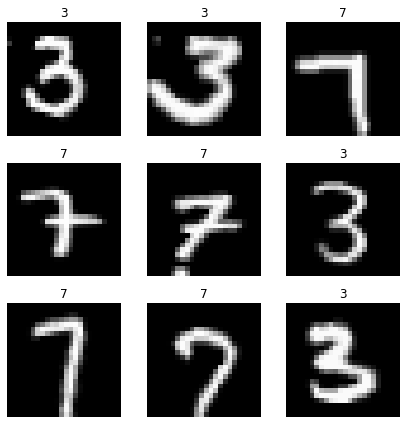

In [34]:
data = ImageDataBunch.from_folder(untar_data(URLs.MNIST_SAMPLE),
                                  ds_tfms=tfms, size=24)
data.normalize()
data.show_batch(rows=3, figsize=(6,6))

**get_annotations**

`get_annotations(fname, prefix=None)`

在fname中打开COCO样式的json并返回文件名列表（可能带有前缀）和标记为bbox的列表。

要使用此数据集并将样本整理为批次，您需要执行以下功能：

**bb_pad_collate**

`bb_pad_collate(samples:BatchSamples, pad_idx:int=0) → Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]`

收集标记的bbox样本并使用pad_idx添加填充的函数。

最后，要将转换应用于数据集中的Image，我们使用最后一个类。

---

## ItemList特定于视觉
视觉应用程序添加了一些特定于图像的ItemList子类。

**class ImageList**

`ImageList(*args, convert_mode='RGB', after_open:Callable=None, **kwargs) :: ItemList`

ItemList适合计算机视觉。

它继承自ItemList并覆盖ItemList.get以调用open_image，以便将Path对象中的图像文件转换为Image对象。 可以为标签指定label_cls，xtra包含任何额外信息（通常以数据帧的形式），并且在拆分和标记后将处理器应用于ItemList。

ImageList .__ init__如何覆盖ItemList .__ init__？

ImageList .__ init__在ItemList .__ init__上创建其他属性，如convert_mode，after_open，c，size。 并且特别需要convert_mode和sizes来使用ImageList.get（它也覆盖ItemList.get）和ImageList.open。

**from_folder**

`from_folder(path:PathOrStr='.', extensions:StrList=None, **kwargs) → ItemList`

获取路径中具有图像后缀的文件列表。 recurse确定我们是否搜索子文件夹。

ImageList.from_folder如何覆盖ItemList.from_folder？

ImageList.from_folder在ItemList.from_folder上添加了一些扩展约束，专门用于处理图像文件; 并且可以采用其他输入参数，如convert_mode和after_open，这些参数对ItemList不可用。

**from_df**

`from_df(df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs) → ItemList`

使用前面的文件夹获取df的cols中的文件名，最后是后缀。

**get_image_files**

`get_image_files(c:PathOrStr, check_ext:bool=True, recurse=False) → FilePathList`

返回c中作为图像的文件列表。 check_ext将过滤为image_extensions。

**open**

`open(fn)`

在fn，子类中打开图像并覆盖自定义行为。

让我们通过以下示例了解open的使用方式。

In [36]:
from fastai.vision import *

In [37]:
path_data = untar_data(URLs.PLANET_TINY); path_data.ls()

[WindowsPath('C:/Users/Yang/.fastai/data/planet_tiny/labels.csv'),
 WindowsPath('C:/Users/Yang/.fastai/data/planet_tiny/train')]

In [38]:
imagelistRGB = ImageList.from_folder(path_data/'train'); imagelistRGB

ImageList (200 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\Yang\.fastai\data\planet_tiny\train

open只接受一个输入fn作为Path或String类型的文件名。

In [39]:
imagelistRGB.items[10]

WindowsPath('C:/Users/Yang/.fastai/data/planet_tiny/train/train_10838.jpg')

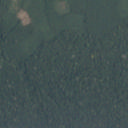

In [40]:
imagelistRGB.open(imagelistRGB.items[10])

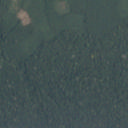

In [41]:
imagelistRGB[10]

In [42]:
print(imagelistRGB[10])

Image (3, 128, 128)


imagelistRGB [10]打印图像的原因是因为幕后我们有ImageList.get调用ImageList.open调用open_image，它使用PIL.Image.open（fn）.convert（convert_mode）打开图像文件（ 我们如何打印图像），最后将其变成具有形状的图像对象（3,128,128）

在内部，ImageList.open将ImageList.convert_mode和ImageList.after_open传递给open_image以调整Image对象的外观。 例如，将convert_mode设置为L可以使图像变为黑白。

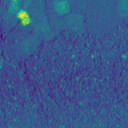

In [43]:
imagelistRGB.convert_mode = 'L'
imagelistRGB.open(imagelistRGB.items[10])

**show_xys**

`show_xys(xs, ys, imgsize:int=4, figsize:Optional[Tuple[int, int]]=None, **kwargs)`

在figsize图上显示xs（输入）和ys（目标）。

**show_xyzs**

`show_xyzs(xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int, int]]=None, **kwargs)`

在figsize图上显示xs（输入），ys（目标）和zs（预测）。

**class ObjectCategoryList**

`ObjectCategoryList(items:Iterator[T_co], classes:Collection[T_co]=None, label_delim:str=None, one_hot:bool=False, **kwargs) :: MultiCategoryList`

标签边界框的ItemList。

**class ObjectItemList**

`ObjectItemList(*args, convert_mode='RGB', after_open:Callable=None, **kwargs) :: ImageList`

ItemList适用于对象 detection.cv

**class SegmentationItemList**

`SegmentationItemList(*args, convert_mode='RGB', after_open:Callable=None, **kwargs) :: ImageList`

ItemList适用于分段任务

**class SegmentationLabelList**

`SegmentationLabelList(items:Iterator[T_co], classes:Collection[T_co]=None, **kwargs) :: ImageList`

分段掩码的ItemList。

**class PointsLabelList**

`PointsLabelList(items:Iterator[T_co], **kwargs) :: ItemList`

点的ItemList。

**class PointsItemList**

`PointsItemList(*args, convert_mode='RGB', after_open:Callable=None, **kwargs) :: ImageList`

ImageList for Image到ImagePoints任务。

**class ImageImageList**

`ImageImageList(*args, convert_mode='RGB', after_open:Callable=None, **kwargs) :: ImageList`

ItemList适用于Image to Image任务。

---

## 构建自己的数据集

该模块还包含一些辅助函数，允许您构建自己的数据集以进行图像分类。

**download_images**

`download_images(urls:StrList, dest:PathOrStr, max_pics:int=1000, max_workers:int=8, timeout=4)`

将文本文件URL中列出的图像下载到路径dest，最多为max_pics

**verify_images**

`verify_images(path:PathOrStr, delete:bool=True, max_workers:int=4, max_size:int=None, recurse:bool=False, dest:PathOrStr='.', n_channels:int=3, interp=2, ext:str=None, img_format:str=None, resume:bool=None, **kwargs)`

检查路径中的图像是否没有损坏，可能会调整它们的大小并将其复制到dest中。

它会尝试打开此文件夹中的每个图像并具有n_channels。 如果n_channels为3  - 它将尝试将图像转换为RGB。 如果delete = True，它将被删除它失败。 如果恢复 - 它将跳过dest中已存在的图像。 如果指定了max_size，则使用interp将图像调整为相同的比例，以使两个尺寸都小于max_size。 结果存储在dest中，ext强制扩展类型，img_format和kwargs传递给PIL.Image.save。 使用max_workers CPU。